# Example 1: Waterflood Simulation in 2D Aquifer using X-MeshGraphNet

## 1. Introduction 

### What is Reservoir Simulation?

Reservoir simulation is a computational technique that predicts reservoir performance using physical and mathematical models. It's crucial for:

- **Production Forecasting**: Estimating how much oil/gas can be recovered
- **Reservoir Management**: Optimizing production strategies
- **Field Development Planning**: Deciding where to drill wells
- **Optimization**: Finding the best operational parameters

### The Challenge
Traditional reservoir simulators are **computationally expensive**. Workflows requiring thousands of simulations (e.g., uncertainty quantification, optimization) can take weeks or months to complete.

### The Solution: Surrogate Modeling with Deep Learning

We can train a **neural network surrogate model** that:
- Learns from high-fidelity simulations
- Predicts reservoir behavior in seconds instead of hours
- Offers acceptable accuracy
- Rapid exploration of different scenarios

## 2. Problem Description 

### Example 1: 2D Quarter Five-Spot Waterflood
In this example, we'll work with a classic reservoir engineering problem. Water is injected to displace oil toward the producer. We will use 1000 samples with different permeability distributions where aech simulation tracks pressure and saturation evolution over time. The high-fidelity simulations are created using **OPM** (Open Porous Media) simulator. Our objective is predict pressure and saturation.

#### Physical Setup

- **Geometry**: 2D quarter five-spot pattern
  - One **injector well** at the corner
  - One **producer well** at the opposite corner
  - 
- **Key Variables**:
  - **PERMX**: Permeability in X-direction (controls how easily fluids flow)
  - **PRESSURE**: Fluid pressure in each grid cell
  - **SWAT**: Water saturation (fraction of pore space filled with water)



## 3. X-MeshGraphNet Overview 

X-MeshGraphNet is a **Graph Neural Network (GNN)** architecture specifically designed for physics simulation on unstructured meshes. Reservoir simulators use a **finite volume** discretization:

```
┌─────┬─────┬─────┐
│ Cell│ Cell│ Cell│  ← Each cell is a graph NODE
│  1  │  2  │  3  │
├─────┼─────┼─────┤
│ Cell│ Cell│ Cell│
│  4  │  5  │  6  │  Connections between cells → EDGES
├─────┼─────┼─────┤
│ Cell│ Cell│ Cell│
│  7  │  8  │  9  │
└─────┴─────┴─────┘
```

This naturally maps to a **graph structure**:
- **Nodes**: Grid cells with properties (pressure, saturation, permeability)
- **Edges**: Flow connections with transmissibility values

Some advantages are: 


| Feature | Key Capabilities | Benefits |
|---------|------------------|----------|
| **Handles Complex Connectivity** | Faults, pinch-outs, discrete fractures, NNCs, dual-porosity systems | Models realistic reservoir geology |
| **Scalable** | Millions of cells, graph partitioning, halo regions | Handles industry-scale models efficiently |
| **Physics-Aware** | Finite volume framework, transmissibility values, autoregressive prediction | Maintains physical consistency |
| **Flexible** | Multiple grid types, multiple phases, time-varying conditions | Adapts to various reservoir scenarios |

## 4. Workflow Overview 

The complete workflow consists of **5 main steps**:

```
┌─────────────────────────────────────────────────────────────┐
│                     X-MGN Workflow Pipeline                 │
└─────────────────────────────────────────────────────────────┘

   Raw Simulation Data                         Trained Model
   (ECLIPSE/IX Format)                         (Predictions)
         │                                           ▲
         │                                           │
         ▼                                           │
┌──────────────────┐    ┌──────────────┐    ┌─────────────┐
│   1. Dataset     │───▶│ 2. Configure │───▶│ 3. Process  │
│   Preparation    │    │   Parameters │    │    Data     │
└──────────────────┘    └──────────────┘    └─────────────┘
                                                     │
                                                     ▼
                                             ┌─────────────┐
                                             │  Graph Data │
                                             │  (.pt files)│
                                             └─────────────┘
                                                     │
                                                     ▼
                                             ┌─────────────┐
                                             │  4. Train   │
                                             │    Model    │
                                             └─────────────┘
                                                     │
                                                     ▼
                                             ┌─────────────┐
                                             │ Checkpoints │
                                             │  (.pt files)│
                                             └─────────────┘
                                                     │
                                                     ▼
                                             ┌─────────────┐
                                             │ 5. Inference│
                                             │ & Visualize │
                                             └─────────────┘
                                                     │
                                                     ▼
                                          ┌──────────────────┐
                                          │ Results (HDF5,   │
                                          │  GRDECL files)   │
                                          └──────────────────┘
```

### Step-by-Step Breakdown

| Step | Description | Input | Output |
|------|-------------|-------|--------|
| **1. Dataset** | Organize simulation files | `.DATA`, `.INIT`, `.EGRID`, `.UNRST` | Structured directory |
| **2. Configure** | Set parameters in YAML | User choice | `config.yaml` |
| **3. Preprocess** | Build graphs, extract features | Simulation files + config | `.pt` graph files |
| **4. Train** | Train neural network | Graph files | Model checkpoints |
| **5. Inference** | Generate predictions | Trained model + test data | HDF5, GRDECL results |

## 5. Prerequisites & Setup
First, ensure you're in the correct directory and have all dependencies installed. You can use the physicsnemo container, or do "pip install -r requirements.txt"

In [1]:
##Install required dependencies (if not already installed)
# !pip install -r requirements.txt

In [2]:
# Import necessary libraries and check gpus available
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"GPU device: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.9.0a0+145a3a7bda.nv25.10
CUDA available: True
CUDA version: 13.0
GPU device: NVIDIA H100 80GB HBM3


## 6. Step 1: Dataset Preparation 

The X-MGN framework expects simulation data in **ECLIPSE/IX format**. This is an industry-standard format used by many reservoir simulators. The required Files per Case

| File Type | Extension | Contents |
|-----------|-----------|----------|
| **Data File** | `.DATA` | Simulation input specification |
| **Initial State** | `.INIT` | Static properties (permeability, porosity) |
| **Grid** | `.EGRID` | Grid geometry and topology |
| **Restart** | `.UNRST` | Dynamic properties over time (pressure, saturation) |
| **Summary** | `.UNSMRY` | Well data and field totals (optional) |

### Example 1 Dataset Structure

For this example, your dataset should be organized as:

```
../dataset/2D_OW/CASE_2D.sim/
├── CASE_001.DATA
├── CASE_001.INIT
├── CASE_001.EGRID
├── CASE_001.UNRST
├── CASE_002.DATA
├── CASE_002.INIT
├── CASE_002.EGRID
├── CASE_002.UNRST
└── ... (1000 cases total)
```

In [3]:
# We will check if the simulations file are in place
dataset_path = Path("../dataset/2D_OW/CASE_2D.sim")

# Check if dataset exists
if dataset_path.exists():
    print(f"Dataset found at: {dataset_path.absolute()}")
    
    # Count simulation cases
    init_files = list(dataset_path.glob("*.INIT"))
    egrid_files = list(dataset_path.glob("*.EGRID"))
    unrst_files = list(dataset_path.glob("*.UNRST"))
    
    print(f"\nDataset Statistics:")
    print(f"  - .INIT files: {len(init_files)}")
    print(f"  - .EGRID files: {len(egrid_files)}")
    print(f"  - .UNRST files: {len(unrst_files)}")
    
else:
    print(f" Dataset not found at: {dataset_path.absolute()}")
    print(f"\n Please ensure your dataset is downloaded and the path in config.yaml is correct.")
    print(f"   Expected location: {dataset_path.absolute()}")

Dataset found at: /workspace/lab_3/xmgn/../dataset/2D_OW/CASE_2D.sim

Dataset Statistics:
  - .INIT files: 10
  - .EGRID files: 10
  - .UNRST files: 10


## 7. Step 2: Configuration 

The configuration file (`conf/config.yaml`) controls all aspects of the workflow. Let's look at the key sections.

### Configuration Structure

The config file is organized into logical sections:

```yaml
├── hydra             # Experiment naming and output directories
├── runspec           # Job description
├── dataset           # Data location and graph features
├── preprocessing     # Graph building parameters
├── model             # Neural network architecture
├── training          # Training hyperparameters
├── performance       # Optimization settings
└── inference         # Prediction settings
```

In [4]:
# View the configuration file
# !cat conf/config.yaml

### Modifying the Configuration

For this tutorial, the default configuration should work well. However, you might want to adjust:

- **`dataset.sim_dir`**: If your data is in a different location
- **`training.num_epochs`**: Reduce for faster testing (e.g., 100)
- **`preprocessing.num_preprocess_workers`**: Match your CPU cores

You can edit the config file directly or create a new config in the `conf/` directory.

## 8. Step 3: Data Preprocessing 

The preprocessing step transforms raw simulation data into graph structures suitable for GNN training.

### Preprocessing Pipeline

```
┌─────────────────────────────────────────────────────────┐
│              Preprocessing Pipeline                     │
└─────────────────────────────────────────────────────────┘

1. Read Binary Files (.INIT, .EGRID, .UNRST)
   ↓
2. Extract Grid Geometry
   - Cell centers (X, Y, Z coordinates)
   - Cell connections (neighbors)
   ↓
3. Extract Node Features
   - Static: PERMX, PORV (from .INIT)
   - Dynamic: PRESSURE, SWAT at each timestep (from .UNRST)
   ↓
4. Extract Edge Features
   - Transmissibility values (TRANX, TRANY, TRANZ)
   ↓
5. Build Graph Structure
   - Nodes: Grid cells with features
   - Edges: Connections with transmissibility
   ↓
6. Create Training Sequences
   - Input: timesteps t-2, t-1, t
   - Target: timestep t+1
   ↓
7. Normalize Features
   - Scale to [0, 1] or apply log transform
   ↓
8. Partition Graphs (if num_partitions > 1)
   - Split into subgraphs
   - Add halo regions
   ↓
9. Save Processed Graphs (.pt files)
```

In [5]:
# %%time
# # Run preprocessing (this may take several minutes depending on dataset size)
# !python src/preprocessor.py --config-name=config

### Expected Output from running preprocessor
```
../dataset/2D_OW/CASE_2D.sim.dataset/XMGN_2D_Q5SP_Waterflood/
├── graphs/              # Raw graph files
├── partitions/          # Partitioned graphs
│   ├── train/
│   ├── val/
│   └── test/
├── global_stats.json    # Normalization statistics
└── dataset_metadata.json
```

### Understanding the Graph Structure

Each processed graph (`.pt` file) contains:

```python
graph = {
    'x': Node features [num_nodes, feature_dim],
         # Concatenation of:
         # - Static features (PERMX, PORV, X, Y, Z)
         # - Dynamic features at t-2, t-1, t for PRESSURE, SWAT, WCID
         #   (total: 3 timesteps × 3 vars = 9 features)
         # - delta_t (time step size) - broadcasted to all nodes [1 feature]
         # - time (normalized 0-1) - broadcasted to all nodes [1 feature]
         # Total: 5 + 9 + 1 + 1 = 16 features per node
    
    'edge_index': Edge connectivity [2, num_edges],
                  # [source_nodes, target_nodes]
    
    'edge_attr': Edge features [num_edges, 1],
                 # Transmissibility values (log10 scaled)
    
    'y': Target values [num_nodes, 2],
         # PRESSURE and SWAT at timestep t+1
    
    'grid_info': dict,
         # Metadata: nx, ny, nz, total_cells, active_cells,
         # sample_idx, timestep_idx, target_timestep,
         # input_vars (list of feature names), target_vars
    
    'case_name': str,
                 # e.g., "CASE_2D_1"
    
    'timestep_id': int,
                   # Current timestep index
    
    'coordinates': [num_nodes, 3],  # ONLY if X,Y,Z NOT in node features
                   # Cell centers (X, Y, Z)
}
```

To see the graph partitioning and halo regions see visualize_regions_graph_2D.ipynb

## 9. Step 4: Model Training 

The training process optimizes the X-MGN model to predict the next timestep given the current and previous states.

```
For each epoch:                                          
    For each batch of partitioned graphs:                
        
        1. Load PARTITIONS (not full graphs):           
           - Each sample has multiple partitions
           - Each partition has inner + halo nodes
        
        2. For each partition:
           - Forward pass: model(x, edge_attr, graph)   
           - Prediction: next timestep (t+1)
           - Extract INNER nodes only                  
        
        3. Compute loss:                              
           - PRESSURE: L2 loss (MSE)                    
           - SWAT: L1 loss (MAE)                        
           - Weighted sum: weights * losses             
           - Gradient accumulation across partitions    
        
        4. Backward pass (per partition):               
           - loss.backward() for each partition
           - Accumulate gradients
        
        5. Update model weights (after all partitions): 
           - optimizer.step()
           - scaler.update() (if GPU/mixed precision)
    
    Every validation_freq epochs (default: 5):          
        - Validate on validation set                    
        - Compute metrics (MAE, RMSE per variable)      
        - Save BEST checkpoint if improved              
        - Save regular checkpoint                       
        - Log metrics to MLflow (automatic)             
        - Check early stopping                          
    
    Update learning rate (cosine annealing):            
        - scheduler.step()
```

In [6]:
# Single GPU training
# Note: This will take significant time (hours) depending on your hardware
# You may want to run this in a terminal session instead

# !python src/train.py --config-name=config

In [7]:
# Multi-GPU training with 8 GPUs (Multi GPU recommended)
# Adjust --nproc_per_node to match your available GPUs
#!torchrun --nproc_per_node=8 --nnodes=1 src/train.py --config-name=config

After training you will see the following output files: 
```
outputs/XMGN_2D_Q5SP_Waterflood/
├── checkpoints/                    # Regular checkpoints (every 5 epochs)
│   ├── checkpoint.0.5.pt
│   ├── checkpoint.0.10.pt
│   └── MeshGraphNet.0.10.mdlus
├── best_checkpoints/               # Best model (lowest val loss)
│   ├── checkpoint.0.25.pt
│   └── MeshGraphNet.0.25.mdlus
├── mlruns/                         # MLflow tracking
│   └── experiment_id/
│       └── run_id/
│           ├── metrics/
│           ├── params/
│           └── artifacts/
└── .hydra/                         # Hydra config snapshots

## 10. Step 5: Inference & Visualization 
During inference, the model predicts future states **autoregressively**:

1. Load trained model from best_checkpoints/
2. Load global statistics (for normalization)
3. Load test dataset (partitioned graphs)
4. Set model to eval mode

```
Initial Conditions (from simulator):
    t=0, t=1, t=2
         ↓
    [X-MGN Model]
         ↓
    Predict t=3
         ↓
Use t=1, t=2, t=3 (predicted) → Predict t=4
         ↓
Use t=2, t=3, t=4 (predicted) → Predict t=5
         ↓
    ... continue for all timesteps
```
After the initial timesteps, the model feeds its own predictions back as input. This is called **autoregressive rollout**.



In [8]:
# Run inference on test set. Checkpoints are provided
# !python src/inference.py --config-name=config

## Results Visualization 

In [9]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

def load_inference_results(h5_file):
    """
    Load inference results from HDF5 file.
    
    Returns:
        predictions: dict of {variable: array[timesteps, nodes]}
        targets: dict of {variable: array[timesteps, nodes]}
        metadata: dict with case info
    """
    with h5py.File(h5_file, 'r') as f:
        predictions = {}
        targets = {}
        
        # Get metadata from attributes
        metadata = {
            'case_name': f.attrs.get('case_name', 'Unknown'),
            'num_timesteps': f.attrs.get('num_timesteps', 0),
            'avg_loss': f.attrs.get('avg_loss', 0),
            'target_variables': f.attrs.get('target_variables', [])
        }
        
        # Load each variable
        for var in ['PRESSURE', 'SWAT']:
            if var in f['predictions']:
                # Get all timestep keys
                timestep_keys = sorted(f[f'predictions/{var}'].keys())
                
                # Load all timesteps into a 2D array
                pred_data = []
                target_data = []
                
                for ts_key in timestep_keys:
                    pred_data.append(f[f'predictions/{var}/{ts_key}'][:])
                    target_data.append(f[f'targets/{var}/{ts_key}'][:])
                
                predictions[var] = np.array(pred_data)  # Shape: [num_timesteps, num_nodes]
                targets[var] = np.array(target_data)
    
    return predictions, targets, metadata

# Get all available cases
h5_files = sorted(Path("outputs/XMGN_2D_Q5SP_Waterflood/inference").glob("*.hdf5"))

print(f"Found {len(h5_files)} inference result files")
print("\nAvailable cases:")
print("-" * 60)
for i, f in enumerate(h5_files[:5]):  # Show first 20
    case_name = f.stem  # Filename without extension
    print(f"  [{i:3d}] {case_name}")
if len(h5_files) > 5:
    print(f"  ... and {len(h5_files) - 5} more cases")

Found 10 inference result files

Available cases:
------------------------------------------------------------
  [  0] CASE_2D_103
  [  1] CASE_2D_120
  [  2] CASE_2D_122
  [  3] CASE_2D_125
  [  4] CASE_2D_14
  ... and 5 more cases



Selected case [0]: CASE_2D_103

Case: CASE_2D_103
Number of timesteps: 18
Average loss: 0.005884

Data shapes:
  Pressure: (18, 441) (timesteps, nodes)
  Saturation: (18, 441) (timesteps, nodes)

Grid dimensions: 21 x 21


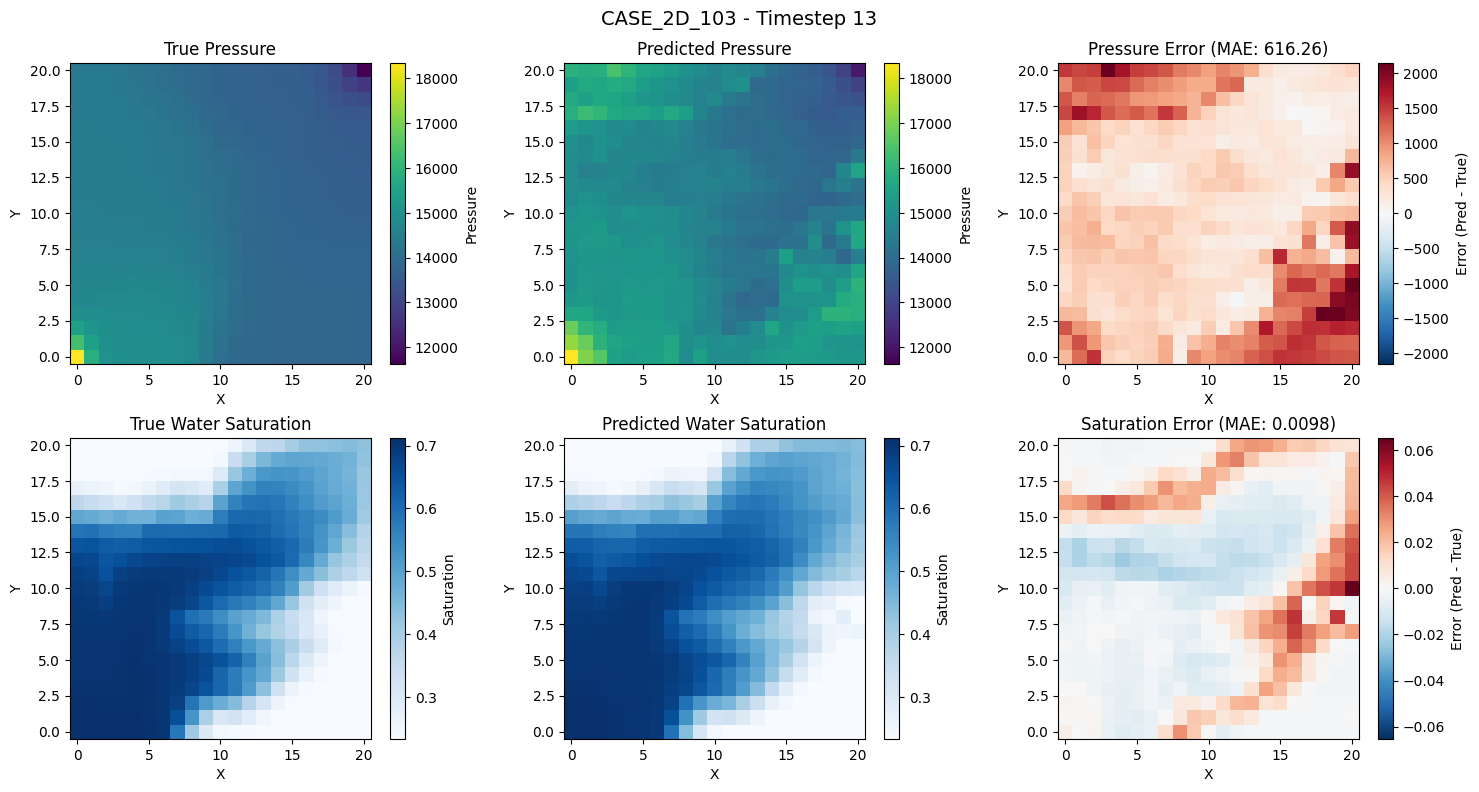

In [10]:
# Change this to select different cases

# Option 1: Select by index
case_index = 0  # Change this number (0 to len(h5_files)-1)

# Option 2: Select by name (uncomment to use)
# case_name = "CASE_2D_308"  # Change this to the case you want
# case_index = next(i for i, f in enumerate(h5_files) if f.stem == case_name)

# Option 3: Random case (uncomment to use)
# import random
# case_index = random.randint(0, len(h5_files)-1)


if len(h5_files) > 0:
    selected_file = h5_files[case_index]
    print(f"\n{'='*60}")
    print(f"Selected case [{case_index}]: {selected_file.stem}")
    print(f"{'='*60}")
    
    predictions, targets, metadata = load_inference_results(selected_file)
    
    print(f"\nCase: {metadata['case_name']}")
    print(f"Number of timesteps: {metadata['num_timesteps']}")
    print(f"Average loss: {metadata['avg_loss']:.6f}")
    print(f"\nData shapes:")
    print(f"  Pressure: {predictions['PRESSURE'].shape} (timesteps, nodes)")
    print(f"  Saturation: {predictions['SWAT'].shape} (timesteps, nodes)")
    
    # Determine grid dimensions (441 = 21x21)
    num_nodes = predictions['PRESSURE'].shape[1]
    grid_size = int(np.sqrt(num_nodes))
    print(f"\nGrid dimensions: {grid_size} x {grid_size}")
    
    # Plot comparison for a specific timestep
    timestep = 10  # Change this to plot different timesteps (0-17)
    
    # Reshape to 2D grid
    pressure_true_2d = targets['PRESSURE'][timestep].reshape(grid_size, grid_size)
    pressure_pred_2d = predictions['PRESSURE'][timestep].reshape(grid_size, grid_size)
    swat_true_2d = targets['SWAT'][timestep].reshape(grid_size, grid_size)
    swat_pred_2d = predictions['SWAT'][timestep].reshape(grid_size, grid_size)
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    fig.suptitle(f"{metadata['case_name']} - Timestep {timestep+3}", fontsize=14)
    
    # Use GROUND TRUTH bounds for consistent comparison
    vmin_p = pressure_true_2d.min()
    vmax_p = pressure_true_2d.max()
    
    im1 = axes[0, 0].imshow(pressure_true_2d, cmap='viridis', vmin=vmin_p, vmax=vmax_p, origin='lower')
    axes[0, 0].set_title('True Pressure')
    axes[0, 0].set_xlabel('X')
    axes[0, 0].set_ylabel('Y')
    plt.colorbar(im1, ax=axes[0, 0], label='Pressure')
    
    im2 = axes[0, 1].imshow(pressure_pred_2d, cmap='viridis', vmin=vmin_p, vmax=vmax_p, origin='lower')
    axes[0, 1].set_title('Predicted Pressure')
    axes[0, 1].set_xlabel('X')
    axes[0, 1].set_ylabel('Y')
    plt.colorbar(im2, ax=axes[0, 1], label='Pressure')
    
    error_p_2d = pressure_pred_2d - pressure_true_2d
    vmin_err_p = -max(abs(error_p_2d.min()), abs(error_p_2d.max()))
    vmax_err_p = max(abs(error_p_2d.min()), abs(error_p_2d.max()))
    
    im3 = axes[0, 2].imshow(error_p_2d, cmap='RdBu_r', vmin=vmin_err_p, vmax=vmax_err_p, origin='lower')
    axes[0, 2].set_title(f'Pressure Error (MAE: {np.abs(error_p_2d).mean():.2f})')
    axes[0, 2].set_xlabel('X')
    axes[0, 2].set_ylabel('Y')
    plt.colorbar(im3, ax=axes[0, 2], label='Error (Pred - True)')
    
    # Use GROUND TRUTH bounds for saturation
    vmin_s = swat_true_2d.min()
    vmax_s = swat_true_2d.max()
    
    im4 = axes[1, 0].imshow(swat_true_2d, cmap='Blues', vmin=vmin_s, vmax=vmax_s, origin='lower')
    axes[1, 0].set_title('True Water Saturation')
    axes[1, 0].set_xlabel('X')
    axes[1, 0].set_ylabel('Y')
    plt.colorbar(im4, ax=axes[1, 0], label='Saturation')
    
    im5 = axes[1, 1].imshow(swat_pred_2d, cmap='Blues', vmin=vmin_s, vmax=vmax_s, origin='lower')
    axes[1, 1].set_title('Predicted Water Saturation')
    axes[1, 1].set_xlabel('X')
    axes[1, 1].set_ylabel('Y')
    plt.colorbar(im5, ax=axes[1, 1], label='Saturation')
    
    error_s_2d = swat_pred_2d - swat_true_2d
    vmin_err_s = -max(abs(error_s_2d.min()), abs(error_s_2d.max()))
    vmax_err_s = max(abs(error_s_2d.min()), abs(error_s_2d.max()))
    
    im6 = axes[1, 2].imshow(error_s_2d, cmap='RdBu_r', vmin=vmin_err_s, vmax=vmax_err_s, origin='lower')
    axes[1, 2].set_title(f'Saturation Error (MAE: {np.abs(error_s_2d).mean():.4f})')
    axes[1, 2].set_xlabel('X')
    axes[1, 2].set_ylabel('Y')
    plt.colorbar(im6, ax=axes[1, 2], label='Error (Pred - True)')
    
    plt.tight_layout()
    plt.show()
    
else:
    print("No HDF5 files found!")

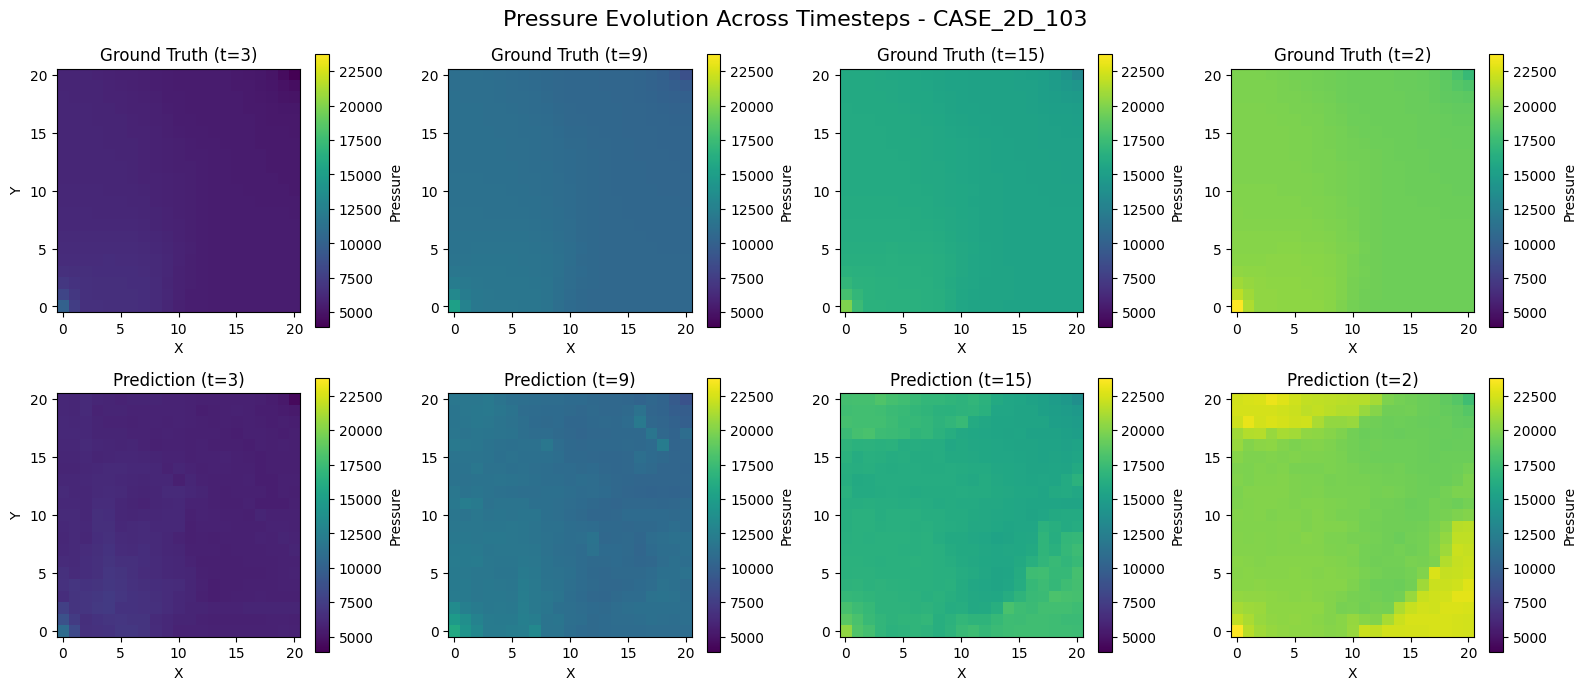

In [11]:
# Visualize pressure evolution
if len(h5_files) > 0 and 'PRESSURE' in predictions:
    
    # Determine grid dimensions
    num_nodes = predictions['PRESSURE'].shape[1]
    grid_size = int(np.sqrt(num_nodes))
    
    # Select timesteps to visualize
    timesteps = [0, len(predictions['PRESSURE'])//3, 2*len(predictions['PRESSURE'])//3, -1]
    
    fig, axes = plt.subplots(2, len(timesteps), figsize=(16, 7))
    fig.suptitle(f'Pressure Evolution Across Timesteps - {metadata["case_name"]}', fontsize=16, y=0.98)
    
    # Get global colorbar bounds from ALL selected timesteps (ground truth)
    vmin_global = min(targets['PRESSURE'][t].min() for t in timesteps)
    vmax_global = max(targets['PRESSURE'][t].max() for t in timesteps)
    
    for i, t in enumerate(timesteps):
        # Reshape to 2D grid
        true_2d = targets['PRESSURE'][t].reshape(grid_size, grid_size)
        pred_2d = predictions['PRESSURE'][t].reshape(grid_size, grid_size)
        
        # Ground truth
        im1 = axes[0, i].imshow(true_2d, cmap='viridis', vmin=vmin_global, vmax=vmax_global, origin='lower')
        axes[0, i].set_title(f'Ground Truth (t={t+3})')
        axes[0, i].set_xlabel('X')
        if i == 0:
            axes[0, i].set_ylabel('Y')
        plt.colorbar(im1, ax=axes[0, i], label='Pressure')
        
        # Prediction
        im2 = axes[1, i].imshow(pred_2d, cmap='viridis', vmin=vmin_global, vmax=vmax_global, origin='lower')
        axes[1, i].set_title(f'Prediction (t={t+3})')
        axes[1, i].set_xlabel('X')
        if i == 0:
            axes[1, i].set_ylabel('Y')
        plt.colorbar(im2, ax=axes[1, i], label='Pressure')
    
    plt.tight_layout()
    plt.show()

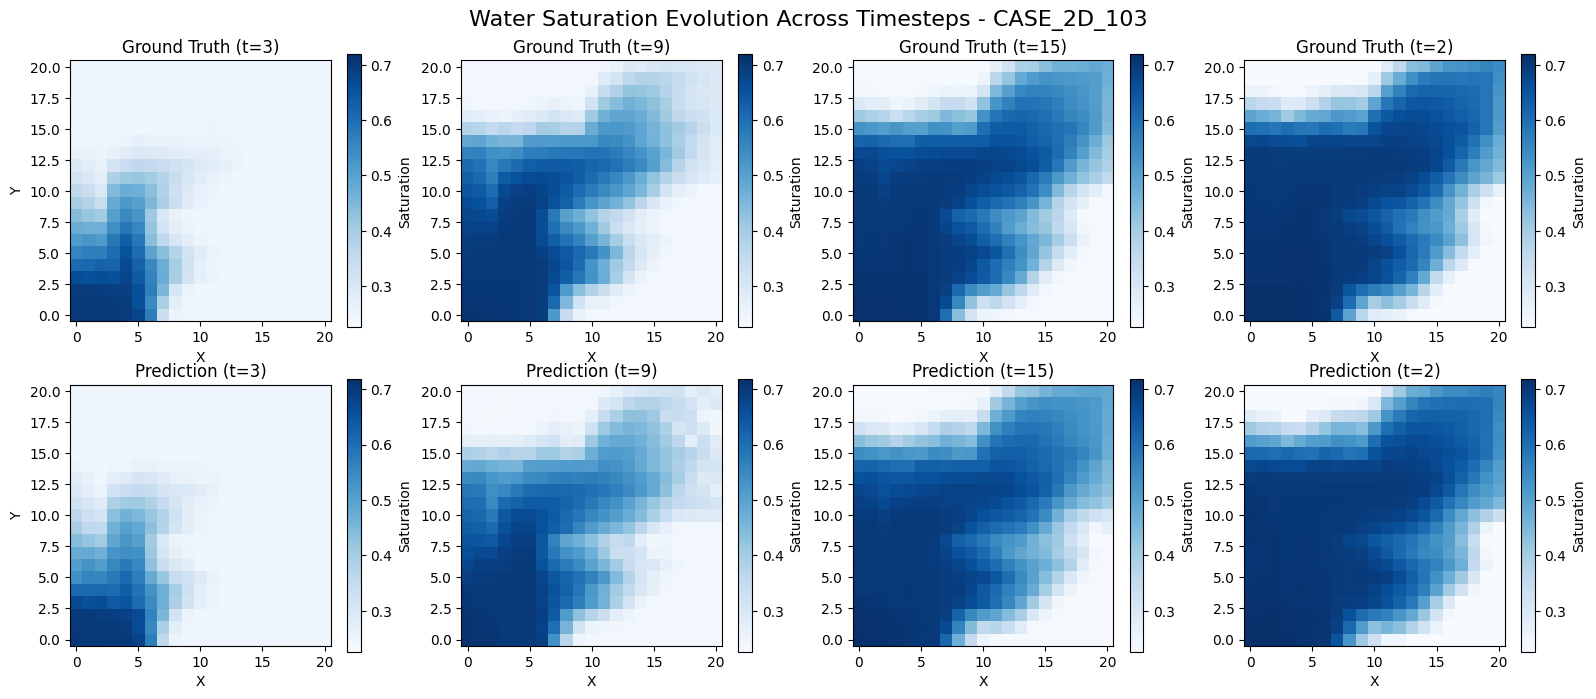

In [12]:
# Visualize saturation evolution
if len(h5_files) > 0 and 'SWAT' in predictions:
    
    # Determine grid dimensions
    num_nodes = predictions['SWAT'].shape[1]
    grid_size = int(np.sqrt(num_nodes))
    
    # Select timesteps to visualize
    timesteps = [0, len(predictions['SWAT'])//3, 2*len(predictions['SWAT'])//3, -1]
    
    fig, axes = plt.subplots(2, len(timesteps), figsize=(16, 7))
    fig.suptitle(f'Water Saturation Evolution Across Timesteps - {metadata["case_name"]}', fontsize=16, y=0.98)
    
    # Get global colorbar bounds from ALL selected timesteps (ground truth)
    vmin_global = min(targets['SWAT'][t].min() for t in timesteps)
    vmax_global = max(targets['SWAT'][t].max() for t in timesteps)
    
    for i, t in enumerate(timesteps):
        # Reshape to 2D grid
        true_2d = targets['SWAT'][t].reshape(grid_size, grid_size)
        pred_2d = predictions['SWAT'][t].reshape(grid_size, grid_size)
        
        # Ground truth
        im1 = axes[0, i].imshow(true_2d, cmap='Blues', vmin=vmin_global, vmax=vmax_global, origin='lower')
        axes[0, i].set_title(f'Ground Truth (t={t+3})')
        axes[0, i].set_xlabel('X')
        if i == 0:
            axes[0, i].set_ylabel('Y')
        plt.colorbar(im1, ax=axes[0, i], label='Saturation')
        
        # Prediction
        im2 = axes[1, i].imshow(pred_2d, cmap='Blues', vmin=vmin_global, vmax=vmax_global, origin='lower')
        axes[1, i].set_title(f'Prediction (t={t+3})')
        axes[1, i].set_xlabel('X')
        if i == 0:
            axes[1, i].set_ylabel('Y')
        plt.colorbar(im2, ax=axes[1, i], label='Saturation')
    
    plt.tight_layout()
    # plt.savefig('saturation_evolution.png', dpi=150, bbox_inches='tight')
    plt.show()
    